### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 6]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import random
import pandas as pd
import os
import sys

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# First simulate a sensible setup:

In [5]:
from codit.disease import Covid
from codit.outbreak import Outbreak
import codit.society as society
import codit.society.lateral as lateral
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation

We are going to work with a small town of a few thousand people.

We will place the population that we have created, into various settings and societies in the upcoming simulations

In [6]:
POP_SIZE = 780000 // 5
PREVALENCE = 1/80
LOCKDOWN_LEVEL = 0.66

In [7]:
pop = CityPopulation(POP_SIZE, society.Society(), person_type=PersonCovid, 
                     lockdown_config={'classrooms': 0, 'workplaces': LOCKDOWN_LEVEL})

2021-04-03 13:49:22,033 INFO:Building a set of 62400 households from which to build a population
2021-04-03 13:49:35,060 INFO:60001 households of mean size 2.60
2021-04-03 13:49:35,885 INFO:29758 buildings of mean size 5.24
2021-04-03 13:49:42,714 INFO:487 classrooms of mean size 23.98
2021-04-03 13:49:42,791 INFO:25 care_homes of mean size 103.28
2021-04-03 13:49:42,968 INFO:18381 workplaces of mean size 5.64
2021-04-03 13:49:43,443 INFO:66.0% of workplaces closed by lockdown, leaving 6611 open, of average Income Decile 4.91 (and st dev 3.15).
2021-04-03 13:49:43,491 INFO:0% of classrooms closed by lockdown, leaving 399 open, of average Income Decile 4.77 (and st dev 3.08).
2021-04-03 13:49:43,499 INFO:Adding 67036 permanent contact groups
2021-04-03 13:49:43,518 INFO:Adding 7800 ephemeral contact pairs
2021-04-03 13:49:43,730 INFO:Adding 46116 contacts each within one of the 29758 buildings (contact density of 0.75)


In [8]:
SCALE_SETTINGS = dict(n_days = 61, pop_size = POP_SIZE, seed_size = int(POP_SIZE*PREVALENCE), population=pop)
SCALE_SETTINGS

{'n_days': 61,
 'pop_size': 156000,
 'seed_size': 1950,
 'population': <codit.population.networks.city.CityPopulation at 0x22b692d6490>}

In [9]:
lf = lateral.LateralFlowUK(config=dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                                       PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.33))
lf.GENERAL_VALENCY_QUANTILE_THRESHOLD = 0.9
lf.VALENCY_TEST_FREQUENCY_DAYS = 3
lf.RETEST_POSITIVE_CASES = True
lf.LATERAL_TO_PCR_RATIO = 15

2021-04-03 13:49:45,158 INFO:The city has 20x the number of lateral flow tests available, as PCRs


In [10]:
o = Outbreak(lf, Covid(), **SCALE_SETTINGS)

In [11]:
o.simulate()

2021-04-03 13:49:48,675 INFO:Setting mass testing valency/degree limit to 21
2021-04-03 13:50:08,407 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0089
2021-04-03 13:56:04,372 INFO:Day 51, prop infected is 0.06, prop infectious is 0.0023
2021-04-03 13:56:58,740 INFO:Day 61, prop infected is 0.06, prop infectious is 0.0016


In [12]:
soc = lf

2021-04-03 13:56:59,307 INFO: Realized R0 of early infections is 0.88
2021-04-03 13:56:59,307 INFO: 5.7 percent of the population was infected during the epidemic


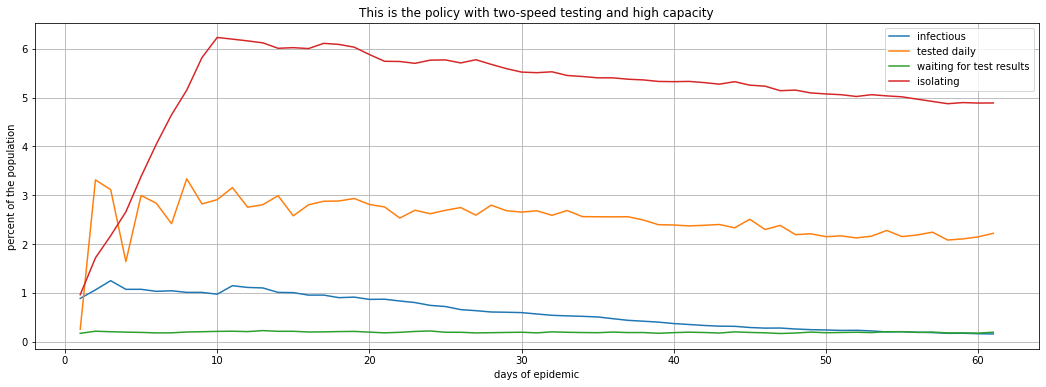

In [13]:
o.plot(title="This is the policy with two-speed testing and high capacity", 
               secondary_y=['prop_infected'])

# Next, take the records of the tests performed:

In [14]:
import pandas as pd

In [15]:
df = pd.DataFrame.from_dict(soc.test_recorder)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239668 entries, 0 to 239667
Data columns (total 12 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   days_elapsed                       239668 non-null  float64
 1   person                             239668 non-null  object 
 2   positive                           239668 non-null  bool   
 3   days_to_complete                   239668 non-null  float64
 4   notes                              239668 non-null  object 
 5   days_delayed_start                 239668 non-null  float64
 6   _succeptible_contacts              239668 non-null  int64  
 7   _succeptible_contacts_of_contacts  239668 non-null  int64  
 8   _days_infected                     12031 non-null   float64
 9   _isolating                         239668 non-null  bool   
 10  _disease                           239668 non-null  object 
 11  swab_taken                         2396

In [17]:
df['contacts'] = df.person.apply(lambda p: len(p.contacts))
df['_infected'] = df._days_infected > 0
df['income_decile'] = df.person.apply(lambda p: int(p.home.lsoa.features['Income_Decile']))

In [18]:
cfg = soc.cfg
df['infectiousness'] = df._disease.apply(lambda d: cfg.PROB_INFECT_IF_TOGETHER_ON_A_DAY.get(d, 0.))
disease_duration = cfg.DAYS_BEFORE_INFECTIOUS + cfg.DAYS_INFECTIOUS_TO_SYMPTOMS + cfg.DAYS_OF_SYMPTOMS 
infectious_duration = cfg.DAYS_INFECTIOUS_TO_SYMPTOMS + cfg.DAYS_OF_SYMPTOMS 

In [19]:
df['_days_yet_infectious'] = df._days_infected.apply(lambda x: min(infectious_duration, disease_duration - x) if not pd.isnull(x) else 0)
df['_reducible_infection_potential'] = df.positive * df._succeptible_contacts * df._days_yet_infectious * df.infectiousness
df['_infection_potential'] = df._infected * df._succeptible_contacts * df._days_yet_infectious * df.infectiousness

In [20]:
df['_second_order_potential'] = df.positive * df._succeptible_contacts_of_contacts * df._days_yet_infectious * df.infectiousness

In [21]:
def simplify_notes(n):
    if type(n) == tuple and n[0] == 'contact':
        if n[1] == 1:
            return 'contact_1'
        return 'contact_2+'
    return n

In [22]:
df['notes'] = df.notes.apply(simplify_notes)

In [23]:
df[df._days_infected > 0].head()

,days_elapsed,person,positive,days_to_complete,notes,days_delayed_start,_succeptible_contacts,_succeptible_contacts_of_contacts,_days_infected,_isolating,_disease,swab_taken,contacts,_infected,income_decile,infectiousness,_days_yet_infectious,_reducible_infection_potential,_infection_potential,_second_order_potential
0,1.0,person 69315,True,0.018809,symptoms,0.0,3,16,6.0,False,SARS-CoV-2,True,3,True,7,0.025,5.0,0.375,0.375,2.000
1,1.0,person 45770,True,0.364253,symptoms,0.0,7,175,6.0,False,SARS-CoV-2,True,7,True,10,0.025,5.0,0.875,0.875,21.875
2,1.0,person 34692,True,0.090449,symptoms,0.0,2,2,6.0,True,SARS-CoV-2,True,2,True,10,0.025,5.0,0.250,0.250,0.250
3,1.0,person 6599,True,0.022133,symptoms,0.0,2,2,6.0,True,SARS-CoV-2,True,2,True,6,0.025,5.0,0.250,0.250,0.250
4,1.0,person 149329,True,0.455722,symptoms,0.0,4,53,6.0,True,SARS-CoV-2,True,4,True,2,0.025,5.0,0.500,0.500,6.625


In [24]:
np.mean(df.contacts[df.positive])  #  * (df.notes.apply(lambda x: 'contact' in x))])

46.39887787056367

In [25]:
np.mean(df.positive) * np.mean(df.contacts[df.positive]) * 5

7.418616586277683

### ML: we aim to learn `y` from `X`, so first lets define `X`:

In [26]:
np.unique(df.contacts)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  53,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 125, 127, 136,
       152], dtype=int64)

In [27]:
set(df.notes)

{'contact_1', 'symptoms', 'valency'}

In [28]:
X = df[['notes', 'contacts']]

# Now implement a bootstrap study:

(this can be refined and much elaborated)

In [29]:
def outcomes(df, outcome, aggregation, agg_name='', index=None):
    index = index or ['notes', 'contacts']
    out = pd.pivot_table(df, values=outcome, index=index, aggfunc=aggregation)[outcome]
    try:
        out = out.unstack(0)
    except:
        pass
    out = pd.DataFrame(out.sort_index())
    out.columns = [x + "_" + agg_name for x in out.columns]
    return out

In [30]:
def bootstrap_resample(S):
    """
    @param S: a function that takes data and gives a statistic we want to know about
    @return: a new function that takes such data, and adds a smidge of randomness to get the bootstrap statistic
    """
    def func(Z):
        """
        @param Z: a numpy.array of data where the first dimension indexes the observations
        """
        Z_resampled = Z[np.random.randint(0, high=len(Z), size=len(Z))]
        return S(Z_resampled)
    return func

In [31]:
def bootstrap_std(x, f):
    return np.std([bootstrap_resample(f)(x.values) for i in range(0, 1000)], axis=0)

In [32]:
def plot_outcomes_with_error(df, outcome, agg, agg_name, index=None, max_contacts=50):
    means = outcomes(df, outcome, agg, agg_name=agg_name, index=index)
    stds = outcomes(df, outcome, lambda x: bootstrap_std(x, agg), agg_name='std', index=index)
    result = pd.concat([means, stds], axis=1)
    if max_contacts and (index is None):
        result = result[result.index < max_contacts]

    result[means.columns].plot(kind='bar', yerr=result[stds.columns].values.T * 2, alpha = 0.5,error_kw=dict(ecolor='k'), grid=True, title=agg_name + " " + outcome)
    plt.axhline(0,color='k')
    plt.axvline(0,color='k')
    return result

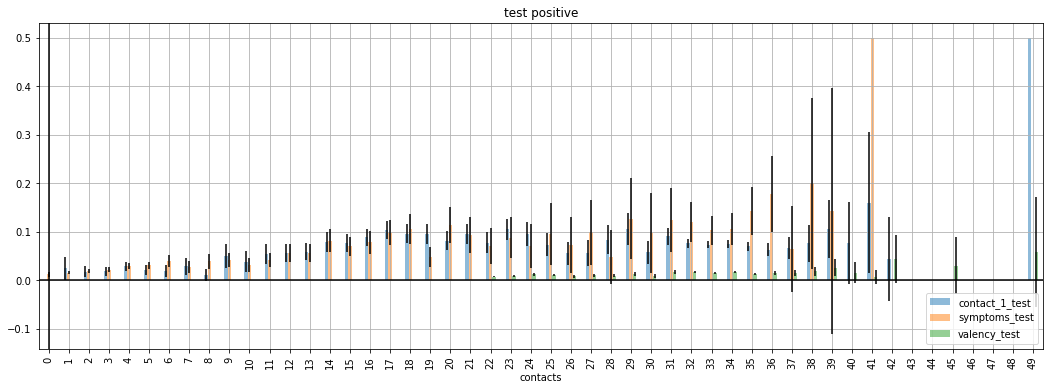

In [33]:
_ = plot_outcomes_with_error(df, 'positive', lambda x: min(0.5, np.mean(x)), 'test')

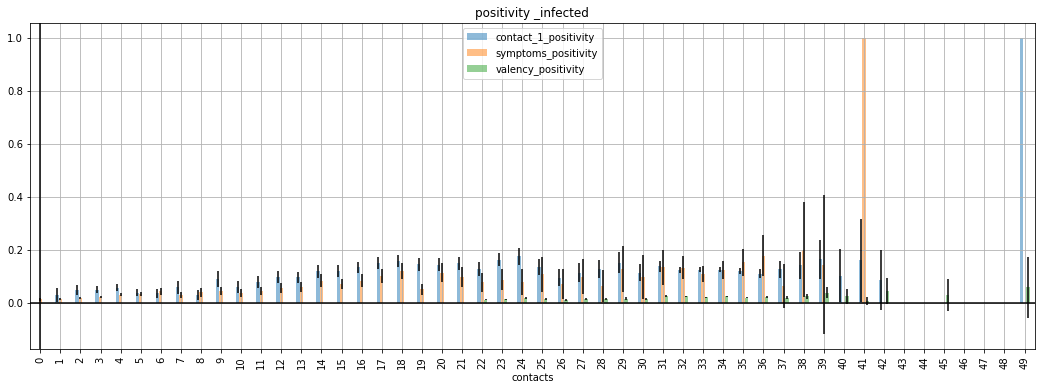

In [42]:
_ = plot_outcomes_with_error(df, '_infected', np.mean, 'positivity')

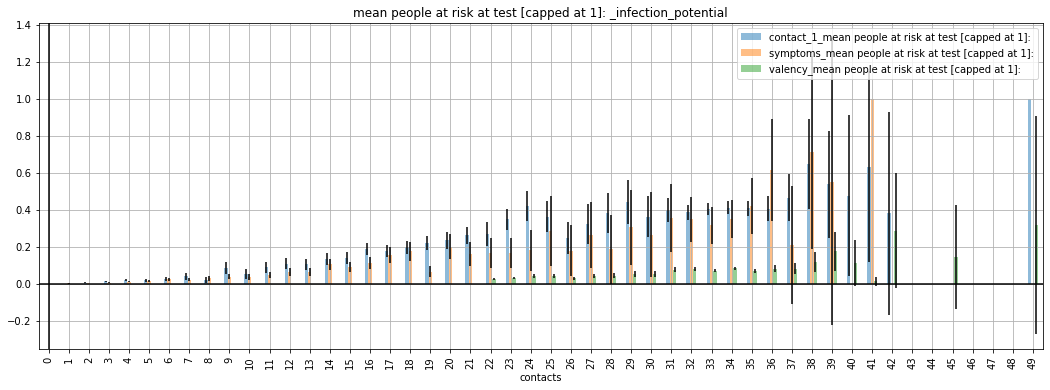

In [35]:
_ = plot_outcomes_with_error(df, '_infection_potential', lambda x: min(1, np.mean(x)), 
                             'mean people at risk at test [capped at 1]:')

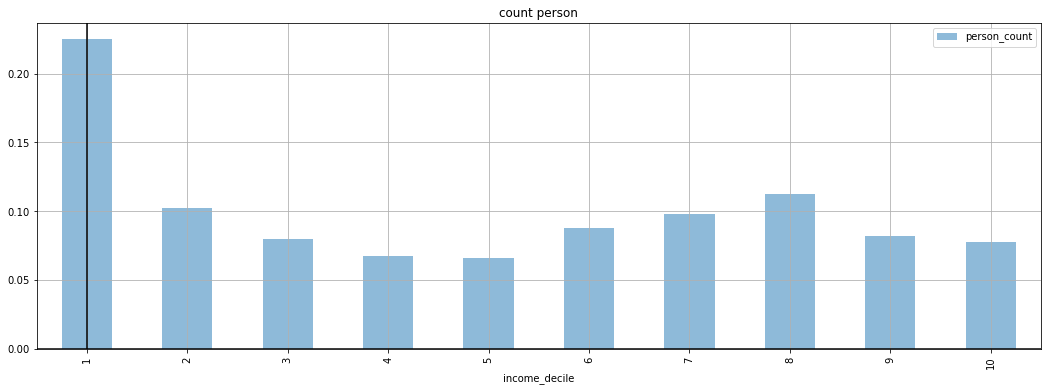

In [36]:
_ = plot_outcomes_with_error(df, 'person', lambda x: len(x) / len(df), 'count', index=['income_decile'])

C:\Users\jerem\anaconda3\envs\codit\lib\site-packages\pandas\plotting\_matplotlib\core.py:584: UserWarning: The handle <BarContainer object of 10 artists> has a label of '_infected_positivity' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


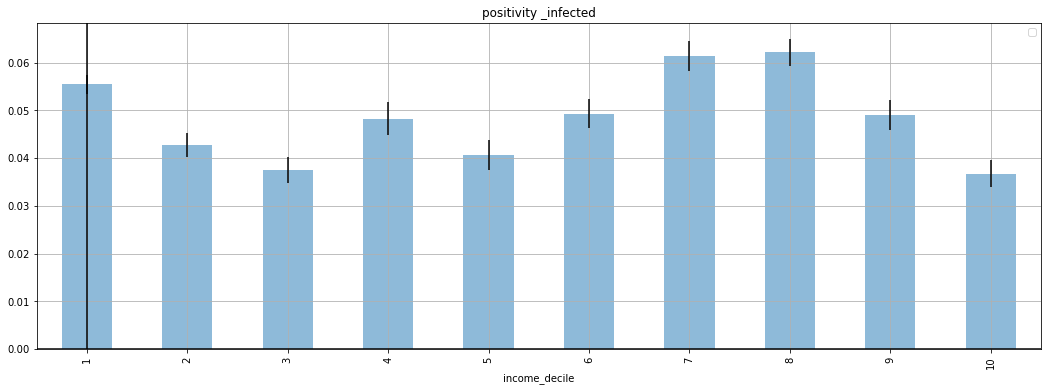

In [43]:
_ = plot_outcomes_with_error(df, '_infected', np.mean, 'positivity', index=['income_decile'])

C:\Users\jerem\anaconda3\envs\codit\lib\site-packages\pandas\plotting\_matplotlib\core.py:584: UserWarning: The handle <BarContainer object of 10 artists> has a label of '_reducible_infection_potential_ : what can be mitigated (in person-days per test)' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


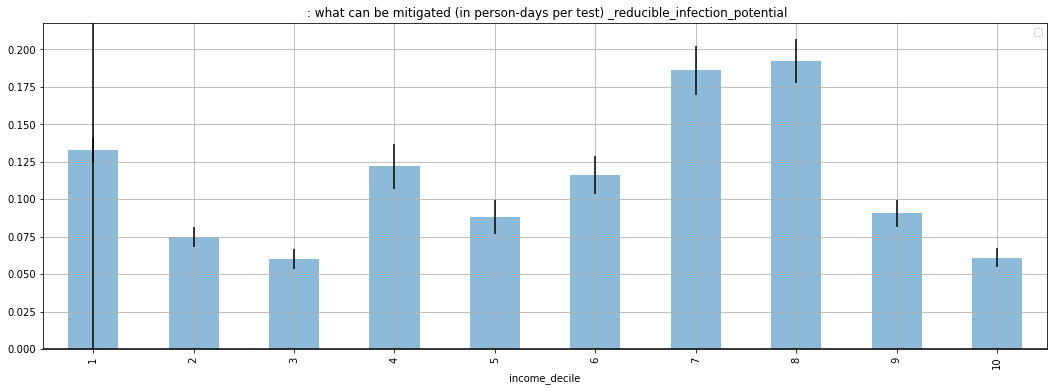

In [37]:
_ = plot_outcomes_with_error(df, '_reducible_infection_potential', lambda x: min(10, np.mean(x)),
                             ' : what can be mitigated (in person-days per test)', index=['income_decile'])

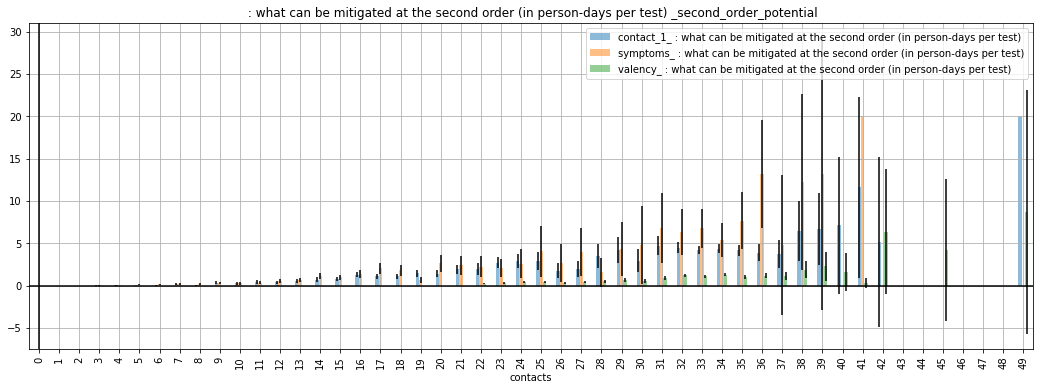

In [38]:
_ = plot_outcomes_with_error(df, '_second_order_potential', lambda x: min(20, np.mean(x)),
                             ' : what can be mitigated at the second order (in person-days per test)')

C:\Users\jerem\anaconda3\envs\codit\lib\site-packages\pandas\plotting\_matplotlib\core.py:584: UserWarning: The handle <BarContainer object of 3 artists> has a label of '_reducible_infection_potential_ : what can be mitigated (in person-days per test)' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


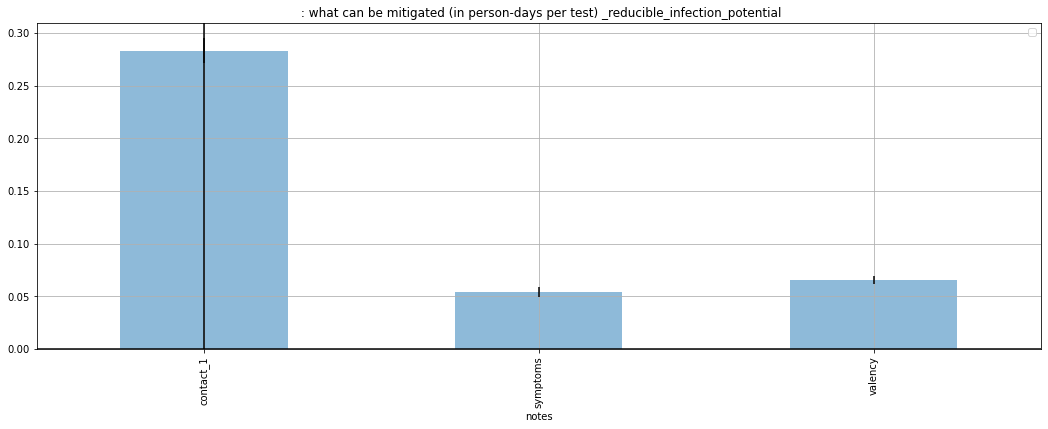

In [39]:
_ = plot_outcomes_with_error(df, '_reducible_infection_potential', lambda x: min(10, np.mean(x)),
                             ' : what can be mitigated (in person-days per test)', index=['notes',], max_contacts=None)

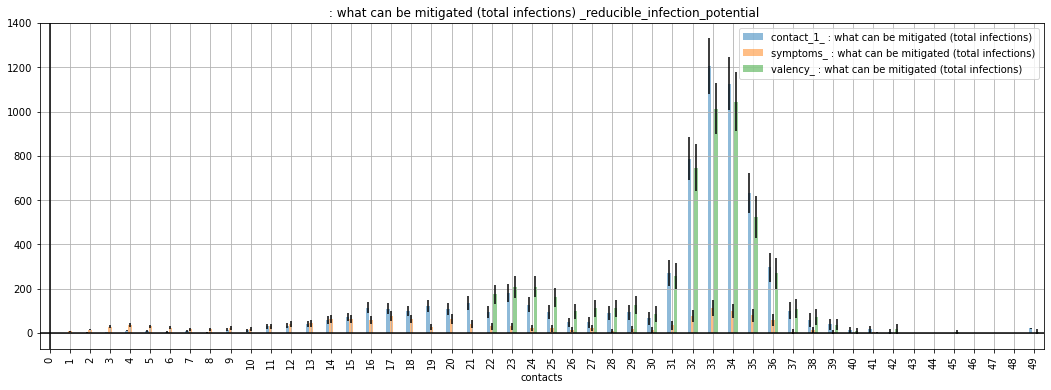

In [40]:
_ = plot_outcomes_with_error(df, '_reducible_infection_potential', np.sum, ' : what can be mitigated (total infections)')

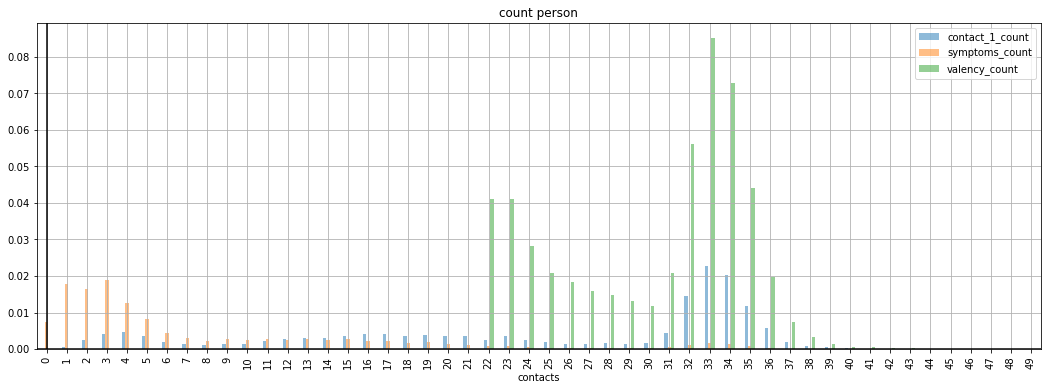

In [41]:
_ = plot_outcomes_with_error(df, 'person', lambda x: len(x) / len(df), 'count')